## Feature Transformations with Ensembles of Trees
Transform your features into a higher dimensional, sparse space. Then train a linear model on these features.

First fit an ensemble of trees (totally random trees, a random forest, or gradient boosted trees) on the training set. Then each leaf of each tree in the ensemble is assigned a fixed arbitrary feature index in a new feature space. These leaf indices are then encoded in a one-hot fashion.

1. Generate the data

First, we will create a large dataset and split it into three sets:
- A set to train the ensemble methods
- A set to train the linear model
- A set to test the linear model

In [19]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

# Import libraries
import matplotlib.pyplot as plt 
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomTreesEmbedding

# Generate the data
X, y = make_classification(n_samples=80_000, random_state=10)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10
)
X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = train_test_split(
    X_train_full, y_train_full, test_size=0.5, random_state=10
)
n_estimator = 10
max_depth = 3

2. Train the classifiers

Second, we will start by training the random forest and gradient boosting on the separated training set.

The `RandomTreesEmbedding` is an unsupervised method and thus does not required to be trained independently.

In [20]:
# Train the Random Forest classifier
random_forest = RandomForestClassifier(
    n_estimators=n_estimator, max_depth=max_depth, random_state=10
)
random_forest.fit(X_train_ensemble, y_train_ensemble)

# Train the Gradient Boosting classifier
gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimator, max_depth=max_depth, random_state=10
)
gradient_boosting.fit(X_train_ensemble, y_train_ensemble)

random_tree = RandomTreesEmbedding(
    n_estimators=n_estimator, max_depth=max_depth, random_state=10
)

3. Create pipelines

Now, we will create three pipelines that will use the above embedding as a preprocessing stage.

The random trees embedding can be directly pipelined with the logistic regression because it is a standard scikit-learn transformer.

In [21]:
# Import the libraries
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Create random trees pipeline
rt_model = make_pipeline(random_tree, LogisticRegression(max_iter=1000))
rt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('randomtreesembedding',
                 RandomTreesEmbedding(max_depth=3, n_estimators=10,
                                      random_state=10)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Then, we can pipeline random forest or gradient boosting with a logistic regression. However, the feature transformation will happen by calling the method `apply`. The pipeline in scikit-learn expects to call to `transform`. Therefore, we wrapped the call to `apply` within a `FunctionTransformer`.

In [22]:
# Import library
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

def rf_apply(X, model):
    return model.apply(X)

# Create random forest pipeline
rf_leaves_yielder = FunctionTransformer(
    rf_apply, kw_args={"model": random_forest}
)
rf_model = make_pipeline(
    rf_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000),
)
rf_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function rf_apply at 0x12dae35e0>,
                                     kw_args={'model': RandomForestClassifier(max_depth=3,
                                                                              n_estimators=10,
                                                                              random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [23]:
def gbdt_apply(X, model):
    return model.apply(X)[:, :, 0]

# Create gradient boosting pipeline
gbdt_leaves_yielder = FunctionTransformer(
    gbdt_apply, kw_args={"model": gradient_boosting}
)
gbdt_model = make_pipeline(
    gbdt_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000),
)
gbdt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function gbdt_apply at 0x12daa4f70>,
                                     kw_args={'model': GradientBoostingClassifier(n_estimators=10,
                                                                                  random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

4. Plot the ROC curves

Show the different ROC curves for all the models.

Text(0.5, 1.0, 'ROC curve')

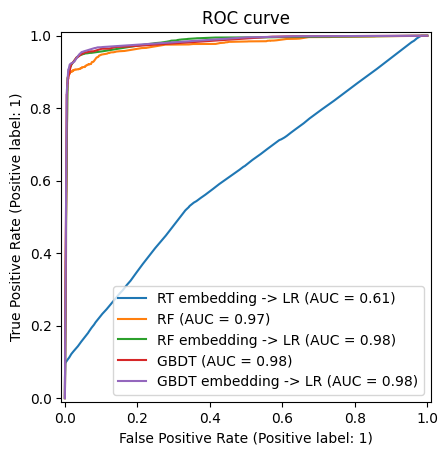

In [24]:
# Plot the ROC curves
fig, ax = plt.subplots()
models = [
    ("RT embedding -> LR", rt_model),
    ("RF", random_forest),
    ("RF embedding -> LR", rf_model),
    ("GBDT", gradient_boosting),
    ("GBDT embedding -> LR", gbdt_model),
]
model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name
    )
ax.set_title("ROC curve")